In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.pooling import GlobalAveragePooling1D

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"
TEST_DATA_MATRIX = "Xt_level_{}.npy"
TEST_LABELS_MATRIX = "yt_{}.npy"

In [7]:
NN_PARAMETER_SEARCH_PREFIX = "standard_nn_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
root_location = "/mnt/virtual-machines/data/"
big_data_location = "/mnt/virtual-machines/data/"

matrices_save_location = big_data_location + "extended_pv_matrices"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

In [9]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 17.9 s, sys: 1.14 s, total: 19 s
Wall time: 19 s


In [10]:
len(training_docs_list)

1286325

In [48]:
data_type_file_dict ={
    "training": TRAINING_DATA_MATRIX,
    "validation": VALIDATION_DATA_MATRIX,
    "test": TEST_DATA_MATRIX,
}
labels_type_file_dict ={
    "training": TRAINING_LABELS_MATRIX,
    "validation": VALIDATION_LABELS_MATRIX,
    "test": TEST_LABELS_MATRIX,
}

def get_data_dirs(classifications_type, level, data_type):
    data_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                data_type_file_dict[data_type].format(level))
    labels_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                labels_type_file_dict[data_type].format(classifications_type))
    return data_dir, labels_dir

def get_data(data_file, labels_file, mmap=False):
    mmap_mode = None
    if mmap == True:
        mmap_mode = "r"
    X_data = np.load(data_file, mmap_mode=mmap_mode)
    y_data = np.load(labels_file, mmap_mode=mmap_mode)
    return X_data, y_data

In [11]:
def get_training_data(classifications_type, level):
    info("Loading Training Data from file")
    training_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                              TRAINING_DATA_MATRIX.format(level))))
    training_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                TRAINING_LABELS_MATRIX.format(classifications_type))))
    return training_data, training_labels

def get_validation_data(classifications_type, level):
    info("Loading Validation Data from file")
    validation_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                VALIDATION_DATA_MATRIX.format(level))))
    validation_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_LABELS_MATRIX.format(classifications_type))))
    return validation_data, validation_labels

def get_test_data(classifications_type, level):
    info("Loading Test Data from file")
    test_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                TEST_DATA_MATRIX.format(level))))
    test_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TEST_LABELS_MATRIX.format(classifications_type))))
    return test_data, test_labels

In [12]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
#             print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [13]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [14]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.3},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [15]:
LEVEL_DOC = 1
LEVEL_DIVISIONS = 2
LEVEL_CHUNKS = 3

In [16]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [17]:
NN_RANDOM_SEARCH_BUDGET = 20
NN_PARAM_SAMPLE_SEED = 1234

In [40]:
GLOBAL_PARMS_TO_RUN = [
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': valid_subclasses,
        'classifications_type': 'subclasses',
        'parts_level': LEVEL_DOC,
        'nn_batch_size': 4096,
    },
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': valid_subclasses,
        'classifications_type': 'subclasses',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 4096,
    }
]


==================================== NEW PARAM SET ============================================
{'classifications_type': 'subclasses', 'parts_level': 1, 'doc2vec_epoch': 8, 'nn_batch_size': 4096}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-14 17:28:31,508 : INFO : Loading Training Documents
2017-04-14 17:28:31,509 : INFO : Loading Training Data from file
2017-04-14 17:28:32,791 : INFO : Loading Validation Documents
2017-04-14 17:28:32,792 : INFO : Loading Validation Data from file


(1286325, 1, 200)
(1286325, 940)


2017-04-14 17:28:33,058 : INFO : Reshaping
2017-04-14 17:28:33,060 : INFO : No Previous results exist in /mnt/virtual-machines/data/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/standard_nn_subclasses_level_1_batch_4096_nn_parameter_searches.pkl
2017-04-14 17:28:33,060 : INFO : ***************************************************************************************
2017-04-14 17:28:33,061 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


(321473, 1, 200)
(321473, 940)
(1286325, 200)
(321473, 200)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          201000      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_6[0][0]                  
_______________________________

<IPython.core.display.Javascript object>


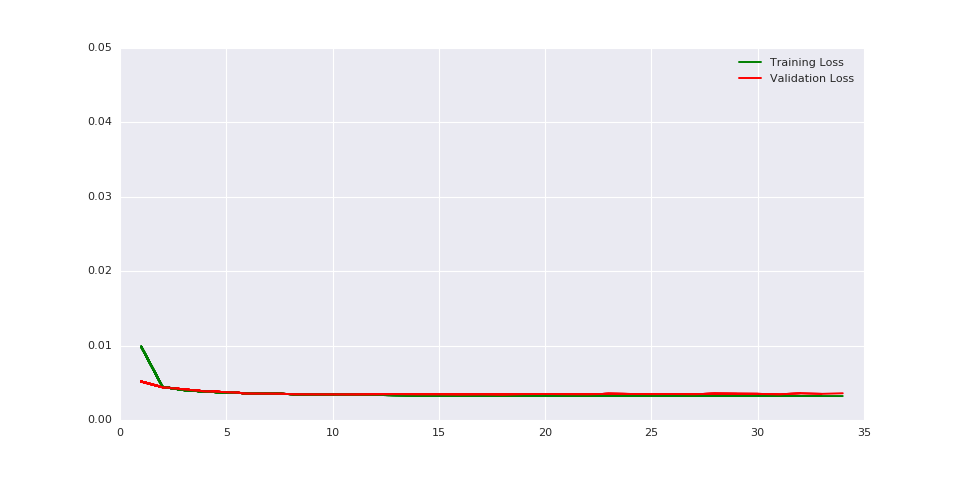

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0098

2017-04-14 17:43:13,885 : INFO : Found lower val loss for epoch 1 => 0.00517


1286325/1286325 [==============================] - 879s - loss: 0.0098 - val_loss: 0.0052
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0045

2017-04-14 17:57:48,754 : INFO : Found lower val loss for epoch 2 => 0.00441


1286325/1286325 [==============================] - 874s - loss: 0.0045 - val_loss: 0.0044
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-14 18:12:23,222 : INFO : Found lower val loss for epoch 3 => 0.00411


1286325/1286325 [==============================] - 874s - loss: 0.0040 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-14 18:26:55,418 : INFO : Found lower val loss for epoch 4 => 0.00385


1286325/1286325 [==============================] - 872s - loss: 0.0038 - val_loss: 0.0038
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-14 18:41:31,834 : INFO : Found lower val loss for epoch 5 => 0.00374


1286325/1286325 [==============================] - 876s - loss: 0.0037 - val_loss: 0.0037
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-14 18:56:03,830 : INFO : Found lower val loss for epoch 6 => 0.00358


1286325/1286325 [==============================] - 871s - loss: 0.0036 - val_loss: 0.0036
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-14 19:10:36,199 : INFO : Found lower val loss for epoch 7 => 0.00353


1286325/1286325 [==============================] - 872s - loss: 0.0035 - val_loss: 0.0035
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-14 19:25:11,328 : INFO : Found lower val loss for epoch 8 => 0.00349


1286325/1286325 [==============================] - 875s - loss: 0.0035 - val_loss: 0.0035
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-14 19:39:54,623 : INFO : Found lower val loss for epoch 9 => 0.00346


1286325/1286325 [==============================] - 883s - loss: 0.0034 - val_loss: 0.0035
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-14 19:54:38,053 : INFO : Found lower val loss for epoch 10 => 0.00344


1286325/1286325 [==============================] - 883s - loss: 0.0034 - val_loss: 0.0034
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-14 20:09:10,530 : INFO : Found lower val loss for epoch 11 => 0.00342


1286325/1286325 [==============================] - 872s - loss: 0.0034 - val_loss: 0.0034
Epoch 12/200
1286325/1286325 [==============================] - 874s - loss: 0.0034 - val_loss: 0.0034
Epoch 13/200
1286325/1286325 [==============================] - 869s - loss: 0.0033 - val_loss: 0.0035
Epoch 14/200
1286325/1286325 [==============================] - 868s - loss: 0.0033 - val_loss: 0.0034
Epoch 15/200
1286325/1286325 [==============================] - 872s - loss: 0.0033 - val_loss: 0.0034
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-14 21:21:45,213 : INFO : Found lower val loss for epoch 16 => 0.00341


1286325/1286325 [==============================] - 869s - loss: 0.0033 - val_loss: 0.0034
Epoch 17/200
1286325/1286325 [==============================] - 868s - loss: 0.0033 - val_loss: 0.0034
Epoch 18/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-14 21:50:41,799 : INFO : Found lower val loss for epoch 18 => 0.00339


1286325/1286325 [==============================] - 868s - loss: 0.0033 - val_loss: 0.0034
Epoch 19/200
1286325/1286325 [==============================] - 873s - loss: 0.0033 - val_loss: 0.0035
Epoch 20/200
1286325/1286325 [==============================] - 870s - loss: 0.0033 - val_loss: 0.0035
Epoch 21/200
1286325/1286325 [==============================] - 870s - loss: 0.0033 - val_loss: 0.0035
Epoch 22/200
1286325/1286325 [==============================] - 869s - loss: 0.0033 - val_loss: 0.0035
Epoch 23/200
1286325/1286325 [==============================] - 870s - loss: 0.0033 - val_loss: 0.0035
Epoch 24/200
1286325/1286325 [==============================] - 868s - loss: 0.0032 - val_loss: 0.0035
Epoch 25/200
1286325/1286325 [==============================] - 869s - loss: 0.0032 - val_loss: 0.0035
Epoch 26/200
1286325/1286325 [==============================] - 867s - loss: 0.0032 - val_loss: 0.0035
Epoch 27/200
1286325/1286325 [==============================] - 867s - loss: 0.0032 - 

2017-04-15 01:42:35,181 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00033: early stopping
CPU times: user 8h 11min 47s, sys: 2min 18s, total: 8h 14min 6s
Wall time: 8h 14min 1s


2017-04-15 01:44:40,515 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 6.835 | Top 3: 0.738 | Top 5: 0.820 | F1 Micro: 0.526 | F1 Macro: 0.166
==================================== NEW PARAM SET ============================================
{'classifications_type': 'subclasses', 'parts_level': 2, 'doc2vec_epoch': 8, 'nn_batch_size': 4096}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-15 01:47:10,133 : INFO : Loading Training Documents
2017-04-15 01:47:10,134 : INFO : Loading Training Data from file
2017-04-15 01:47:12,586 : INFO : Loading Validation Documents
2017-04-15 01:47:12,587 : INFO : Loading Validation Data from file


(1286325, 4, 200)
(1286325, 940)


2017-04-15 01:47:13,182 : INFO : Reshaping
2017-04-15 01:47:13,183 : INFO : No Previous results exist in /mnt/virtual-machines/data/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/standard_nn_subclasses_level_2_batch_4096_nn_parameter_searches.pkl
2017-04-15 01:47:13,184 : INFO : ***************************************************************************************
2017-04-15 01:47:13,185 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


(321473, 4, 200)
(321473, 940)
(1286325, 800)
(321473, 800)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 800)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          801000      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_7[0][0]                  
_______________________________

<IPython.core.display.Javascript object>


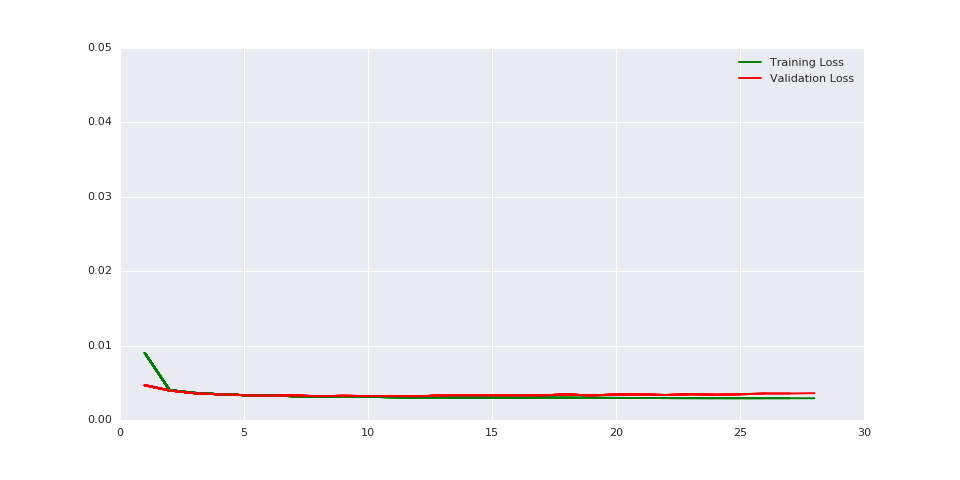

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0090

2017-04-15 02:05:50,073 : INFO : Found lower val loss for epoch 1 => 0.00467


1286325/1286325 [==============================] - 1115s - loss: 0.0090 - val_loss: 0.0047
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-15 02:24:22,743 : INFO : Found lower val loss for epoch 2 => 0.00397


1286325/1286325 [==============================] - 1112s - loss: 0.0040 - val_loss: 0.0040
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-15 02:42:57,253 : INFO : Found lower val loss for epoch 3 => 0.00361


1286325/1286325 [==============================] - 1114s - loss: 0.0036 - val_loss: 0.0036
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-15 03:01:31,876 : INFO : Found lower val loss for epoch 4 => 0.00346


1286325/1286325 [==============================] - 1114s - loss: 0.0035 - val_loss: 0.0035
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-15 03:20:07,153 : INFO : Found lower val loss for epoch 5 => 0.00334


1286325/1286325 [==============================] - 1115s - loss: 0.0033 - val_loss: 0.0033
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-15 03:38:38,624 : INFO : Found lower val loss for epoch 6 => 0.00326


1286325/1286325 [==============================] - 1111s - loss: 0.0033 - val_loss: 0.0033
Epoch 7/200
1286325/1286325 [==============================] - 1112s - loss: 0.0032 - val_loss: 0.0033
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-15 04:15:44,980 : INFO : Found lower val loss for epoch 8 => 0.00321


1286325/1286325 [==============================] - 1114s - loss: 0.0032 - val_loss: 0.0032
Epoch 9/200
1286325/1286325 [==============================] - 1111s - loss: 0.0031 - val_loss: 0.0032
Epoch 10/200
1286325/1286325 [==============================] - 1112s - loss: 0.0031 - val_loss: 0.0032
Epoch 11/200
1286325/1286325 [==============================] - 1121s - loss: 0.0031 - val_loss: 0.0032
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0031

2017-04-15 05:30:03,699 : INFO : Found lower val loss for epoch 12 => 0.00319


1286325/1286325 [==============================] - 1113s - loss: 0.0031 - val_loss: 0.0032
Epoch 13/200
1286325/1286325 [==============================] - 1118s - loss: 0.0030 - val_loss: 0.0033
Epoch 14/200
1286325/1286325 [==============================] - 1113s - loss: 0.0030 - val_loss: 0.0033
Epoch 15/200
1286325/1286325 [==============================] - 1115s - loss: 0.0030 - val_loss: 0.0033
Epoch 16/200
1286325/1286325 [==============================] - 1114s - loss: 0.0030 - val_loss: 0.0033
Epoch 17/200
1286325/1286325 [==============================] - 1116s - loss: 0.0030 - val_loss: 0.0033
Epoch 18/200
1286325/1286325 [==============================] - 1117s - loss: 0.0030 - val_loss: 0.0034
Epoch 19/200
1286325/1286325 [==============================] - 1113s - loss: 0.0030 - val_loss: 0.0033
Epoch 20/200
1286325/1286325 [==============================] - 1114s - loss: 0.0030 - val_loss: 0.0034
Epoch 21/200
1286325/1286325 [==============================] - 1114s - loss:

2017-04-15 10:27:45,691 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00027: early stopping
CPU times: user 8h 30min 27s, sys: 10min 8s, total: 8h 40min 35s
Wall time: 8h 40min 32s


2017-04-15 10:30:17,922 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 5.912 | Top 3: 0.767 | Top 5: 0.846 | F1 Micro: 0.583 | F1 Macro: 0.200


2017-04-15 10:32:46,979 : INFO : Loading Previous results from /mnt/virtual-machines/data/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/standard_nn_subclasses_level_2_batch_4096_nn_parameter_searches.pkl


In [41]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    print GLOBAL_VARS.MODEL_NAME
    
    time.sleep(0.2)
    
    info("Loading Training Documents")
    X, y = get_training_data(classifications_type, PARTS_LEVEL)
    print X.shape
    print y.shape
    
    info("Loading Validation Documents")
    Xv, yv = get_validation_data(classifications_type, PARTS_LEVEL)
    print Xv.shape
    print yv.shape
    
    info("Reshaping")
    X = np.reshape(X, (X.shape[0], X.shape[1]* X.shape[2]))
    Xv = np.reshape(Xv, (Xv.shape[0], Xv.shape[1]* Xv.shape[2]))
    print X.shape
    print Xv.shape
    
    
    NN_INPUT_NEURONS = X.shape[1]
    NN_OUTPUT_NEURONS = len(classifications)
    
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    first_hidden_layer_sizes = [100,200,500,1000]
    second_hidden_layer_sizes = [None,500,1000,2000]
    first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
    second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
    # first_hidden_layer_activations = ['relu']
    # second_hidden_layer_activations = ['relu']
    # input_dropout_options = [False, True]
    # hidden_dropout_options = [False, True]
    input_dropout_options = [False]
    hidden_dropout_options = [True]
    second_hidden_dropout_options = [False]

    
    first_hidden_layer_sizes = [1000]
    second_hidden_layer_sizes = [500,]
    first_hidden_layer_activations = ['sigmoid']
    second_hidden_layer_activations = ['relu']
    # first_hidden_layer_activations = ['relu']
    # second_hidden_layer_activations = ['relu']
    # input_dropout_options = [False, True]
    # hidden_dropout_options = [False, True]
    input_dropout_options = [False]
    hidden_dropout_options = [True]
    second_hidden_dropout_options = [False]
    NN_RANDOM_SEARCH_BUDGET = 1


    np.random.seed(NN_SEED)
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}

    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))

    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results in {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    
    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options,
        'second_hidden_dropout':second_hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)


    for parameters in param_sampler:
        start_time = time.time()
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        second_hidden_dropout_do = parameters['second_hidden_dropout']

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )
        if second_hidden_dropout_do:
            GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

        if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
            print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
            continue
            

        info('***************************************************************************************')
        info(GLOBAL_VARS.NN_MODEL_NAME)

        model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
        model.summary()

        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA,
                                                      patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
        metrics_callback = MetricsCallback()

        # Model Fitting
        %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                                  nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, callbacks=[early_stopper, metrics_callback])


        # using the recorded weights of the best recorded validation loss
        last_model_weights = model.get_weights()
        info('Evaluating on Validation Data using saved best weights')
        model.set_weights(metrics_callback.best_weights)
        yvp = model.predict(Xv)
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
            validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'])
        best_validation_metrics = validation_metrics
        
        time.sleep(0.2)
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

        duration = time.time() - start_time
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

        del history, last_model_weights, metrics_callback

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(param_results_path, 'w'))

## Testing

In [65]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [66]:
TEST_METRICS_FILENAME = '{}_level_{}_test_metrics.pkl'

In [67]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
epoch = DOC2VEC_EPOCH

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [68]:
NN_BATCH_SIZE = 4096

In [76]:
PARTS_LEVEL = 2

In [77]:
param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
param_results_dict = pickle.load(open(param_results_path))

In [78]:
Xt, yt = get_test_data(classifications_type, PARTS_LEVEL)

2017-04-15 21:23:22,129 : INFO : Loading Test Data from file


In [79]:
info("Reshaping")
Xt = np.reshape(Xt, (Xt.shape[0], Xt.shape[1]* Xt.shape[2]))
print Xt.shape

2017-04-15 21:23:24,132 : INFO : Reshaping


(401877, 800)


In [80]:
NN_INPUT_NEURONS = Xt.shape[1]
NN_OUTPUT_NEURONS = len(classifications)

In [81]:
param_results_dict.keys()

['nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True']

In [82]:
first_hidden_layer_size = 1000
first_hidden_layer_activation = 'sigmoid'
second_hidden_layer_size = 500
second_hidden_layer_activation = 'relu'
input_dropout_do = False
hidden_dropout_do = True
second_hidden_dropout_do = False

GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
    first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
    second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
)
if second_hidden_dropout_do:
    GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

    
info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                              first_hidden_layer_size, first_hidden_layer_activation, 
                              second_hidden_layer_size, second_hidden_layer_activation, 
                              input_dropout_do, hidden_dropout_do)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

info('Evaluating on Test Data using best weights')
ytp = model.predict(Xt)
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    
pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL)), 'w'))


2017-04-15 21:23:27,168 : INFO : ***************************************************************************************
2017-04-15 21:23:27,169 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
2017-04-15 21:23:27,349 : INFO : Evaluating on Test Data using best weights


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 800)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          801000      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_11[0][0]                 
___________________________________________________________________________________________

2017-04-15 21:26:38,072 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 5.860, Avg Labels: 1.340, 
		 Top 1: 0.627, Top 3: 0.768, Top 5: 0.845, 
		 F1 Micro: 0.583, F1 Macro: 0.201, Total Pos: 379,836
